<a href="https://colab.research.google.com/github/MichyBliss/Diabetes-prediction/blob/main/Diabetes_prediction_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/diabetes_prediction_dataset.csv')

In [ ]:
# Data Cleaning
# Check for missing values
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


In [ ]:
# Drop duplicates
df.drop_duplicates(inplace=True)

In [ ]:
# Replace zeroes in certain columns with NaN (if medically implausible)
cols_with_zero_invalid = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']



In [ ]:
# Impute missing values with median
df.fillna(df.median(numeric_only=True), inplace=True)

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [ ]:
# Identify categorical columns
categorical_cols = ['gender', 'smoking_history']

In [ ]:
# Apply Ordinal Encoding
encoder = OrdinalEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols])

In [ ]:
# Exploratory Data Analysis (EDA)
# Summary statistics
print("\nSummary statistics:\n", df.describe())


Summary statistics:
              gender           age  hypertension  heart_disease  \
count  96146.000000  96146.000000  96146.000000   96146.000000   
mean       0.416065     41.794326      0.077601       0.040803   
std        0.493287     22.462948      0.267544       0.197833   
min        0.000000      0.080000      0.000000       0.000000   
25%        0.000000     24.000000      0.000000       0.000000   
50%        0.000000     43.000000      0.000000       0.000000   
75%        1.000000     59.000000      0.000000       0.000000   
max        2.000000     80.000000      1.000000       1.000000   

       smoking_history           bmi   HbA1c_level  blood_glucose_level  \
count     96146.000000  96146.000000  96146.000000         96146.000000   
mean          2.231159     27.321461      5.532609           138.218231   
std           1.879963      6.767716      1.073232            40.909771   
min           0.000000     10.010000      3.500000            80.000000   
25%     

df.describe() provides statistics (count, mean, std, min, max, quartiles) for numerical columns.

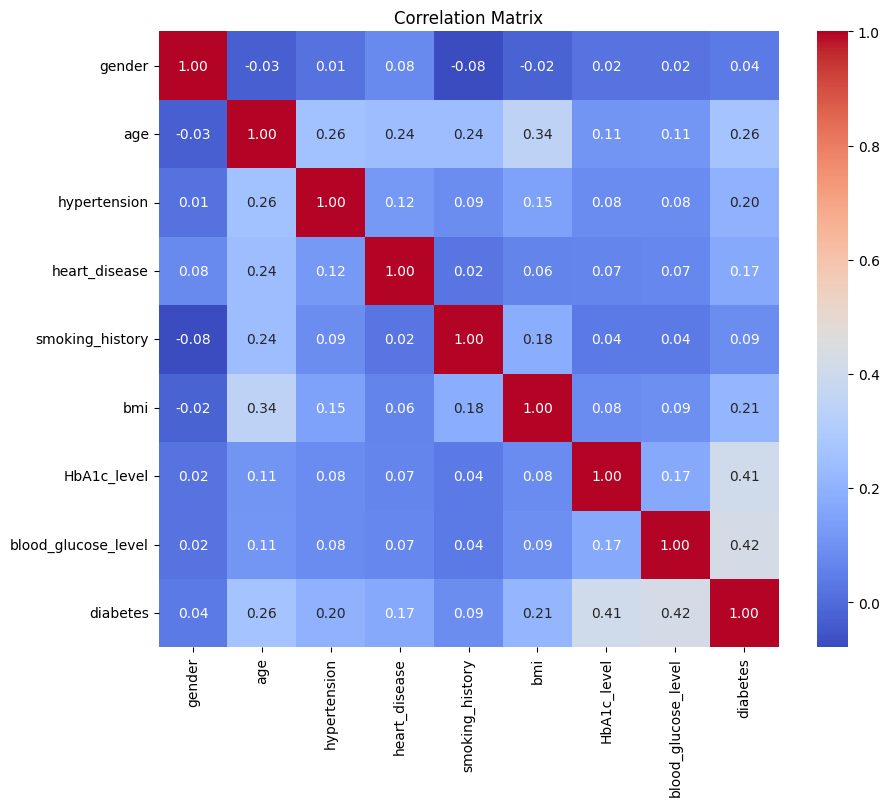

In [ ]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()

+1: Perfect positive correlation as one variable increases, the other increases proportionally.
0: No linear correlation.
-1:Perfect negative correlation as one variable increases, the other decreases proportionally.

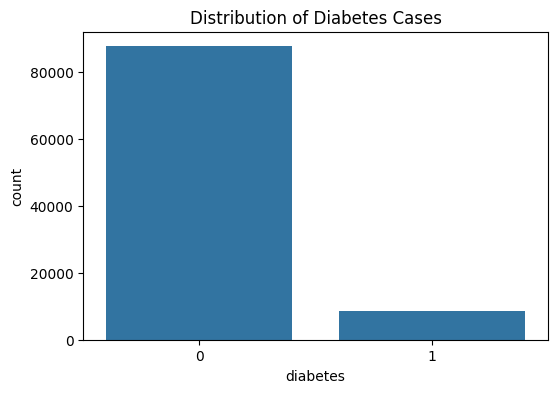

In [ ]:
# Distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='diabetes', data=df)
plt.title('Distribution of Diabetes Cases')
plt.savefig('diabetes_distribution.png')
plt.show()

The plot will have two bars: one for diabetes = 0 (no diabetes) and one for diabetes = 1 (diabetes), with the height of each bar representing the number of occurrences

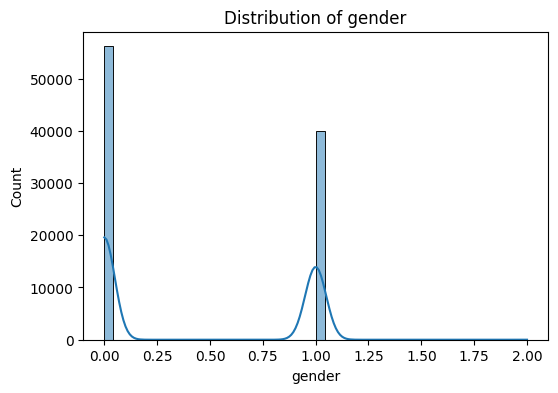

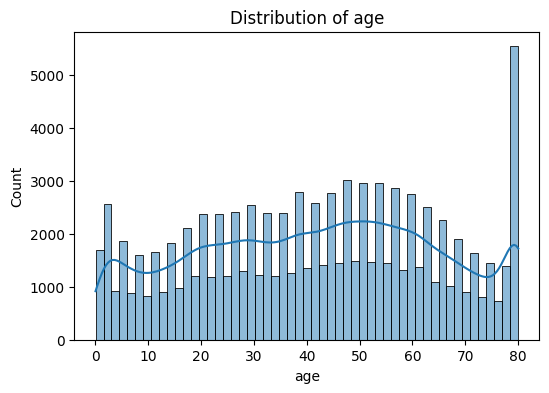

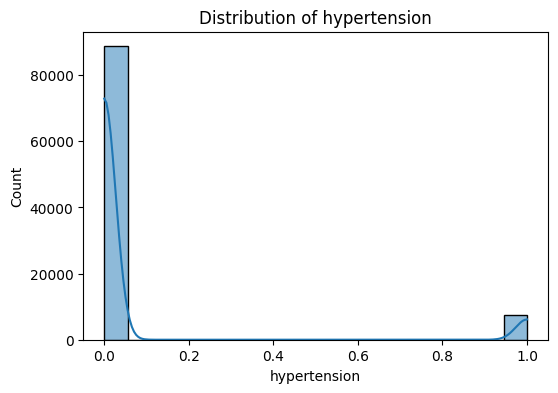

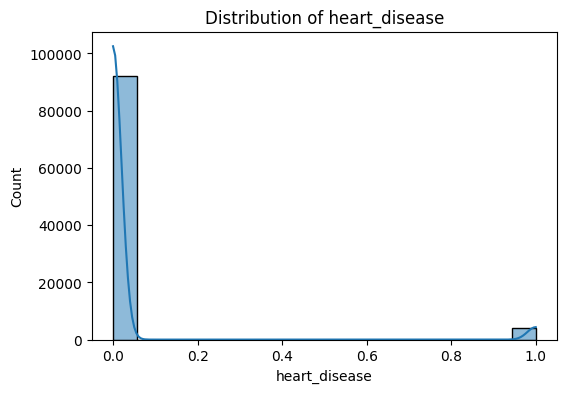

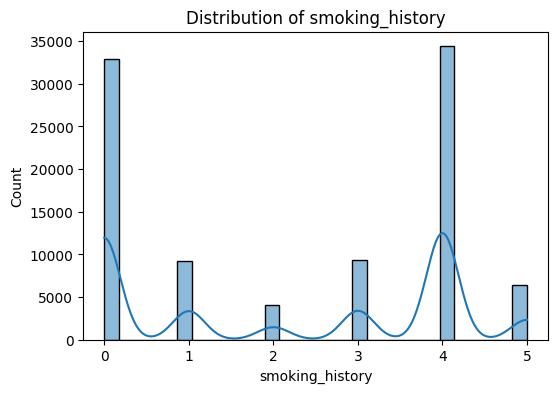

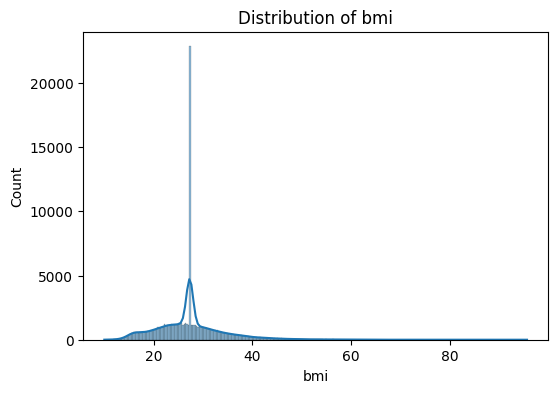

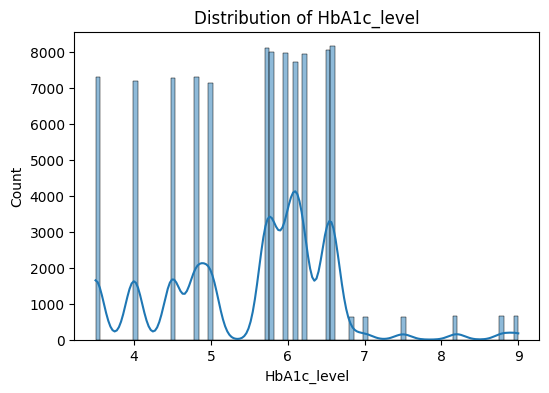

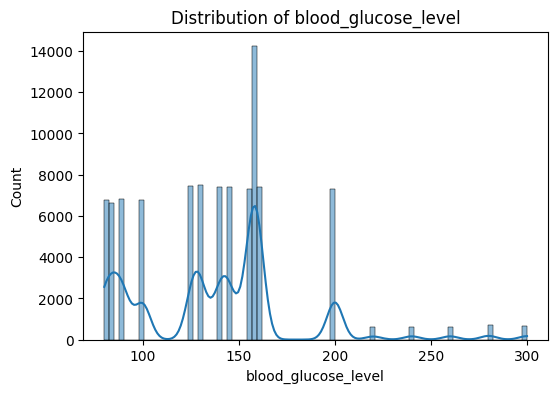

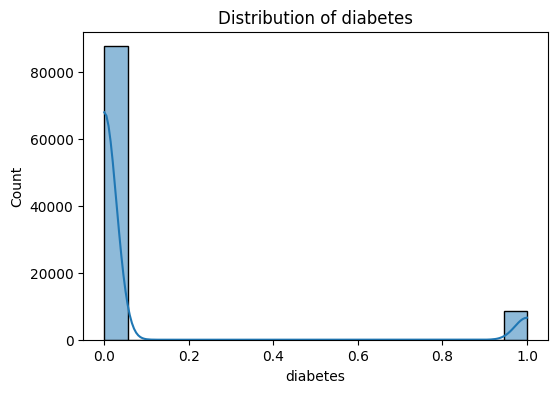

In [ ]:
# Feature distributions
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.savefig(f'distribution_{col}.png')
    plt.show()

** introducing binned features to improve the model interpretability and potentially its performance.**

In [ ]:
# Define bins and labels
# AGE
age_bins = [0, 18, 35, 50, 65, 80]
age_labels = ['Teen', 'Young Adult', 'Middle Age', 'Senior', 'Elderly']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)


diabetes risk increases with age — so models might find it easier to learn this pattern from grouped categories rather than raw age numbers

In [ ]:
# BMI
bmi_bins = [0, 18.5, 24.9, 29.9, 40, 100]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Severely Obese']
df['bmi_category'] = pd.cut(df['bmi'], bins=bmi_bins, labels=bmi_labels)


Obesity is a known risk factor for diabetes, so breaking BMI into health categories can improve model interpretability.

In [ ]:
# Glucose
glucose_bins = [0, 99, 125, 200, 1000]
glucose_labels = ['Normal', 'Prediabetic', 'Diabetic', 'Severe']
df['glucose_status'] = pd.cut(df['blood_glucose_level'], bins=glucose_bins, labels=glucose_labels)

These categories correspond directly to clinical diagnosis thresholds, improving both prediction and interpretability.


In [ ]:
# --- Encoding Categorical Variables ---
categorical_cols = ['gender', 'smoking_history', 'age_group', 'bmi_category', 'glucose_status']
encoder = OrdinalEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols])

# **Model Training and Evaluation**

---




In [ ]:
# Preparing the data for modeling
X = df.drop('diabetes', axis=1)
y = df['diabetes']


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

the data for machine learning, by splitting and scaling. X = df.drop('diabetes', axis=1): Creates the feature matrix by dropping the target column.
y = df['diabetes']: Defines the target variable (0 or 1 for diabetes). train_test_split splits data into training (80%) and testing (20%) sets.
test_size=0.2: Allocates 20% for testing.
random_state=42: Ensures reproducibility.

In [ ]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [35]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier()
}

In [36]:
# Train and evaluate each models
for name, model in models.items():
    print(f"\n{name} Evaluation:")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("Cross-Validation Scores:")
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(cv_scores)


Logistic Regression Evaluation:
Confusion Matrix:
[[17190   319]
 [  964   757]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9469    0.9818    0.9640     17509
           1     0.7035    0.4399    0.5413      1721

    accuracy                         0.9333     19230
   macro avg     0.8252    0.7108    0.7527     19230
weighted avg     0.9251    0.9333    0.9262     19230

Cross-Validation Scores:
[0.93926157 0.94570701 0.93541006 0.93707421 0.93608612]

Random Forest Evaluation:
Confusion Matrix:
[[17428    81]
 [  534  1187]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9703    0.9954    0.9827     17509
           1     0.9361    0.6897    0.7942      1721

    accuracy                         0.9680     19230
   macro avg     0.9532    0.8425    0.8885     19230
weighted avg     0.9672    0.9680    0.9658     19230

Cross-Validation Scores:
[0.96864275 0.96947319 0.96682095 0

In [37]:
# Filter the results to class 1 (diabetic cases)
diabetes_class_results = results_df[results_df['Class'] == '1']

# Sort by F1-Score or Recall
best_by_f1 = diabetes_class_results.sort_values(by='F1-Score', ascending=False)
best_by_recall = diabetes_class_results.sort_values(by='Recall', ascending=False)

# Display top performers
print("🏆 Best Models by F1-Score for Diabetic Class:")
print(best_by_f1[['Model', 'Precision', 'Recall', 'F1-Score']].head(3))

print("\n🏆 Best Models by Recall for Diabetic Class:")
print(best_by_recall[['Model', 'Precision', 'Recall', 'F1-Score']].head(3))


🏆 Best Models by F1-Score for Diabetic Class:
            Model  Precision    Recall  F1-Score
21        XGBoost   0.962903  0.693783  0.806484
6   Random Forest   0.937746  0.691458  0.795987
16            KNN   0.864739  0.538640  0.663802

🏆 Best Models by Recall for Diabetic Class:
            Model  Precision    Recall  F1-Score
21        XGBoost   0.962903  0.693783  0.806484
6   Random Forest   0.937746  0.691458  0.795987
16            KNN   0.864739  0.538640  0.663802


balanced performance ✅ XGBoost, Best F1-Score     
few false alarms     ✅ Random Forest, Highest Precision  
detect all diabetics ✅ XGBoost, Highest Recall    


In [39]:
# Check the result
print(df[['age', 'age_group', 'bmi', 'bmi_category', 'blood_glucose_level', 'glucose_status']].head(10))

    age  age_group    bmi  bmi_category  blood_glucose_level  glucose_status
0  80.0        0.0  25.19           2.0                  140             0.0
1  54.0        2.0  27.32           2.0                   80             1.0
2  28.0        4.0  27.32           2.0                  158             0.0
3  36.0        1.0  23.45           0.0                  155             0.0
4  76.0        0.0  20.14           0.0                  155             0.0
5  20.0        4.0  27.32           2.0                   85             1.0
6  44.0        1.0  19.31           0.0                  200             0.0
7  79.0        0.0  23.86           0.0                   85             1.0
8  42.0        1.0  33.64           1.0                  145             0.0
9  32.0        4.0  27.32           2.0                  100             2.0
